In [10]:
import os
import math
import numpy as np
import librosa
import hmmlearn.hmm as hmm
import pickle
import wave
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [11]:
# Danh sách các nhãn
class_names = ['1.1', '1.2', '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '1.10']

# # Số trạng thái của mỗi mô hình HMM tương ứng với mỗi nhãn
states = [8, 5, 5, 7, 6, 5, 6, 5, 6, 6]

In [12]:
def get_mfcc(file_path):
    y, sr = librosa.load(file_path)
    hop_length = math.floor(sr * 0.010) # 10ms hop
    win_length = math.floor(sr * 0.025) # 25ms frame
    # Tính toán MFCC, delta và delta-delta
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=1024, hop_length=hop_length, win_length=win_length)
    mfcc = mfcc - np.mean(mfcc, axis=1).reshape((-1, 1)) # Chuẩn hóa MFCC
    delta1 = librosa.feature.delta(mfcc, order=1)
    delta2 = librosa.feature.delta(mfcc, order=2)
    X = np.concatenate([mfcc, delta1, delta2], axis=0) # Kết hợp các đặc trưng
    return X.T 

In [13]:
def prepare_data(base_directory):
    all_data = {}
    all_labels = {}
    for cname in class_names:
        directory = os.path.join(base_directory, cname)
        file_paths = [os.path.join(directory, i) for i in os.listdir(directory) if i.endswith('.wav')]
        
        data = []
        for file_path in file_paths:
            mfcc_features = get_mfcc(file_path)
            # Thêm dữ liệu MFCC vào danh sách
            data.append(mfcc_features)

        all_data[cname] = data
        all_labels[cname] = [class_names.index(cname) for i in range(len(file_paths))]
    return all_data, all_labels

train_data, train_labels = prepare_data('D:/PBL5/PBL5_CODE/DemoHMM/DATASET_phanloai/train')

In [14]:
# Huấn luyện và lưu mô hình
def train_and_save_models(all_data, all_labels):
    if not os.path.exists('D:/PBL5/PBL5_CODE/DemoHMM/model_train'):
        os.makedirs('D:/PBL5/PBL5_CODE/DemoHMM/model_train')

    
    # Tạo hai đồ thị trống
    fig1, ax1 = plt.subplots()
    ax1.set_title('Convergence of the model')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Log-likelihood')

    fig2, ax2 = plt.subplots()
    ax2.set_title('Convergence of the model')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Change in Log-likelihood')

    models = {}
    for idx, cname in enumerate(class_names):
        start_prob = np.full(states[idx], 0.0)
        start_prob[0] = 1.0
        trans_matrix = np.full((states[idx], states[idx]), 0.0)
        p = 0.5
        np.fill_diagonal(trans_matrix, p)
        np.fill_diagonal(trans_matrix[0:, 1:], 1 - p)
        trans_matrix[-1, -1] = 1.0

        print(f"Training {cname}")

        models[cname] = hmm.GMMHMM(
            n_components=states[idx],
            startprob_prior=start_prob,
            transmat_prior=trans_matrix,
            verbose=True,
            n_iter=300,
            params='stmc',
            init_params='mc',
            random_state=42,
            algorithm='viterbi',
            covariance_type='diag',
            tol=0.001,
            n_mix=3
        )

        models[cname].fit(X=np.vstack(all_data[cname]), lengths=[x.shape[0] for x in all_data[cname]])

        # Lấy log-likelihood sau mỗi lần lặp và chuyển đổi thành danh sách
        log_likelihoods = list(models[cname].monitor_.history)
        # Vẽ đường cho log-likelihood
        ax1.plot(log_likelihoods, label=cname)
        # Tính sự thay đổi của log-likelihood
        diffs = [j-i for i, j in zip(log_likelihoods[:-1], log_likelihoods[1:])]
        # Vẽ đường cho sự thay đổi của log-likelihood
        ax2.plot(diffs, label=cname)

    ax1.legend(ncol=2)
    ax2.legend(ncol=2)
    plt.show()

    # Lưu tất cả các mô hình vào một file model.pkl
    with open('D:/PBL5/PBL5_CODE/DemoHMM/model_train/model1.pkl', 'wb') as file:
        pickle.dump(models, file)

    print("\nTraining and saving models done!!!")

Training 1.1


         1 -189020.20570636             +nan
         2 -174741.40345878  +14278.80224758
         3 -171940.01453339   +2801.38892539
         4 -170561.13998487   +1378.87454853
         5 -169856.22171251    +704.91827235
         6 -169530.19367131    +326.02804121
         7 -169367.43747169    +162.75619962
         8 -169262.91377561    +104.52369608
         9 -169192.21118546     +70.70259014
        10 -169127.09123723     +65.11994823
        11 -169088.09643924     +38.99479799
        12 -169043.24174825     +44.85469099
        13 -169016.33928554     +26.90246272
        14 -169002.51282766     +13.82645788
        15 -168987.38093473     +15.13189293
        16 -168972.36731264     +15.01362209
        17 -168962.20775080     +10.15956184
        18 -168952.82206786      +9.38568295
        19 -168950.88871697      +1.93335089
        20 -168949.86782062      +1.02089635
        21 -168948.42100133      +1.44681929
        22 -168946.09359630      +2.32740503
        23

Training 1.2


         1 -225715.67227327             +nan
         2 -210556.49546947  +15159.17680380
         3 -206071.76982303   +4484.72564643
         4 -204804.51427765   +1267.25554538
         5 -204384.03487327    +420.47940438
         6 -204171.69342671    +212.34144656
         7 -203986.21809515    +185.47533156
         8 -203895.04041545     +91.17767970
         9 -203853.70298014     +41.33743531
        10 -203821.43281915     +32.27016099
        11 -203797.39348029     +24.03933887
        12 -203777.78809537     +19.60538491
        13 -203755.50387704     +22.28421833
        14 -203724.96626762     +30.53760942
        15 -203669.65572361     +55.31054401
        16 -203649.29299247     +20.36273115
        17 -203624.22651466     +25.06647780
        18 -203585.75563724     +38.47087743
        19 -203528.08908034     +57.66655689
        20 -203487.15560940     +40.93347094
        21 -203450.72358656     +36.43202284
        22 -203439.11194036     +11.61164620
        23

Training 1.3


         1 -211793.33340076             +nan
         2 -198021.31647255  +13772.01692821
         3 -193954.59757834   +4066.71889422
         4 -192737.29555622   +1217.30202211
         5 -192331.03413905    +406.26141718
         6 -192142.37407997    +188.66005907
         7 -192034.96919263    +107.40488735
         8 -191976.72068216     +58.24851047
         9 -191930.16795613     +46.55272603
        10 -191887.50465042     +42.66330570
        11 -191858.53515736     +28.96949306
        12 -191837.09844177     +21.43671559
        13 -191822.27663401     +14.82180776
        14 -191809.43899429     +12.83763972
        15 -191797.23689263     +12.20210166
        16 -191790.32781430      +6.90907833
        17 -191785.05744576      +5.27036854
        18 -191780.58436437      +4.47308139
        19 -191776.94431888      +3.64004550
        20 -191773.81525444      +3.12906444
        21 -191768.91137132      +4.90388312
        22 -191760.91874767      +7.99262365
        23

Training 1.4


         1 -185779.64386103             +nan
         2 -172436.66841648  +13342.97544455
         3 -169353.60136701   +3083.06704947
         4 -168375.80444241    +977.79692461
         5 -167981.65564001    +394.14880240
         6 -167794.83915607    +186.81648393
         7 -167634.12176133    +160.71739475
         8 -167532.60959224    +101.51216909
         9 -167438.35019240     +94.25939984
        10 -167376.34561024     +62.00458216
        11 -167341.68714641     +34.65846383
        12 -167318.56667736     +23.12046905
        13 -167299.19649814     +19.37017922
        14 -167280.18176086     +19.01473729
        15 -167262.73176318     +17.44999768
        16 -167250.36869789     +12.36306529
        17 -167240.48368531      +9.88501257
        18 -167229.52094341     +10.96274190
        19 -167220.15705207      +9.36389134
        20 -167211.71969785      +8.43735423
        21 -167197.21006595     +14.50963190
        22 -167185.19861225     +12.01145370
        23

Training 1.5


         1 -219109.95923167             +nan
         2 -208234.53312376  +10875.42610791
         3 -205731.78783600   +2502.74528776
         4 -204395.90907454   +1335.87876146
         5 -203878.57030776    +517.33876678
         6 -203681.44218518    +197.12812258
         7 -203563.69623310    +117.74595208
         8 -203468.53653954     +95.15969356
         9 -203323.42262456    +145.11391498
        10 -203186.92505425    +136.49757030
        11 -203071.49076069    +115.43429356
        12 -202984.53007648     +86.96068422
        13 -202923.82104876     +60.70902771
        14 -202872.66867864     +51.15237013
        15 -202844.35526854     +28.31341010
        16 -202811.71080322     +32.64446532
        17 -202749.21809821     +62.49270502
        18 -202731.76469909     +17.45339912
        19 -202722.02008424      +9.74461485
        20 -202713.32782138      +8.69226286
        21 -202703.17259831     +10.15522307
        22 -202696.36536429      +6.80723402
        23

Training 1.6


         1 -221481.58731763             +nan
         2 -208072.57859184  +13409.00872578
         3 -205779.98665546   +2292.59193638
         4 -205159.46028688    +620.52636859
         5 -204827.62966582    +331.83062105
         6 -204633.88466756    +193.74499826
         7 -204454.59661298    +179.28805459
         8 -204327.85313053    +126.74348244
         9 -204236.55335221     +91.29977833
        10 -204152.35229462     +84.20105759
        11 -204098.35991046     +53.99238416
        12 -204024.65552416     +73.70438630
        13 -203985.32535335     +39.33017081
        14 -203961.04474554     +24.28060781
        15 -203924.50780191     +36.53694363
        16 -203905.32116881     +19.18663310
        17 -203885.87372971     +19.44743910
        18 -203866.33446995     +19.53925976
        19 -203858.23965798      +8.09481197
        20 -203851.14657055      +7.09308744
        21 -203843.49414184      +7.65242870
        22 -203833.42876101     +10.06538083
        23

Training 1.7


         1 -204756.71288026             +nan
         2 -193339.28346446  +11417.42941579
         3 -191580.28115247   +1759.00231200
         4 -190790.22447357    +790.05667890
         5 -190343.85801617    +446.36645740
         6 -190165.22632574    +178.63169043
         7 -190032.27585759    +132.95046814
         8 -189947.01917830     +85.25667929
         9 -189878.05269264     +68.96648566
        10 -189848.08716801     +29.96552463
        11 -189817.58946025     +30.49770776
        12 -189789.59118192     +27.99827834
        13 -189765.88199443     +23.70918749
        14 -189751.56523300     +14.31676143
        15 -189742.30862590      +9.25660710
        16 -189728.82182889     +13.48679701
        17 -189714.73476356     +14.08706534
        18 -189698.75596518     +15.97879838
        19 -189679.63876524     +19.11719994
        20 -189668.06088920     +11.57787604
        21 -189650.88432338     +17.17656582
        22 -189641.10509160      +9.77923178
        23

Training 1.8


         1 -204276.05748377             +nan
         2 -190316.99467981  +13959.06280396
         3 -187666.04372004   +2650.95095977
         4 -187081.09709615    +584.94662390
         5 -186739.59461325    +341.50248290
         6 -186482.86958750    +256.72502575
         7 -186290.93324505    +191.93634245
         8 -186103.83129671    +187.10194834
         9 -185922.53456742    +181.29672929
        10 -185776.84257694    +145.69199048
        11 -185703.03753741     +73.80503953
        12 -185649.89488313     +53.14265429
        13 -185613.70844018     +36.18644295
        14 -185589.98428768     +23.72415250
        15 -185561.93766070     +28.04662698
        16 -185512.60660212     +49.33105858
        17 -185369.93600315    +142.67059898
        18 -185285.04915399     +84.88684916
        19 -185216.33283220     +68.71632178
        20 -185162.22543164     +54.10740057
        21 -185114.59064819     +47.63478345
        22 -185095.24810729     +19.34254090
        23

Training 1.9


         1 -186732.32519370             +nan
         2 -175409.11190236  +11323.21329135
         3 -173925.18467488   +1483.92722748
         4 -173320.43147666    +604.75319822
         5 -172904.00732374    +416.42415292
         6 -172615.28922817    +288.71809557
         7 -172394.17951260    +221.10971557
         8 -172226.97421361    +167.20529898
         9 -172119.57431086    +107.39990275
        10 -172031.28843126     +88.28587960
        11 -171960.83245129     +70.45597997
        12 -171912.59284942     +48.23960187
        13 -171876.48988372     +36.10296571
        14 -171831.96085978     +44.52902394
        15 -171815.71380751     +16.24705227
        16 -171809.56705205      +6.14675545
        17 -171806.33292553      +3.23412652
        18 -171803.19186163      +3.14106390
        19 -171796.33042866      +6.86143297
        20 -171768.38107729     +27.94935137
        21 -171714.29439808     +54.08667921
        22 -171673.17507140     +41.11932667
        23

Training 1.10


         1 -223051.86466987             +nan
         2 -206875.73554519  +16176.12912468
         3 -204121.38422803   +2754.35131716
         4 -203320.51917464    +800.86505339
         5 -202985.16046509    +335.35870954
         6 -202838.58344483    +146.57702026
         7 -202782.96132665     +55.62211818
         8 -202744.88236803     +38.07895861
         9 -202727.43817123     +17.44419681
        10 -202699.10933954     +28.32883169
        11 -202680.23178337     +18.87755617
        12 -202656.77776270     +23.45402067
        13 -202636.47027904     +20.30748366
        14 -202611.61838226     +24.85189678
        15 -202569.77616827     +41.84221399
        16 -202554.13777933     +15.63838893
        17 -202543.40824327     +10.72953606
        18 -202537.48702826      +5.92121501
        19 -202529.72455254      +7.76247573
        20 -202518.51287446     +11.21167808
        21 -202512.76792555      +5.74494890
        22 -202498.56907995     +14.19884561
        23

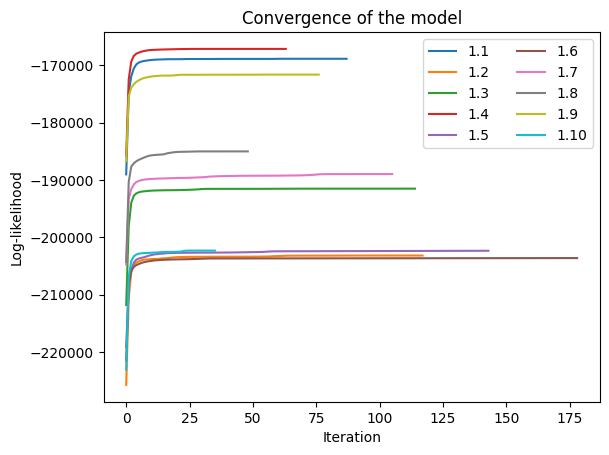

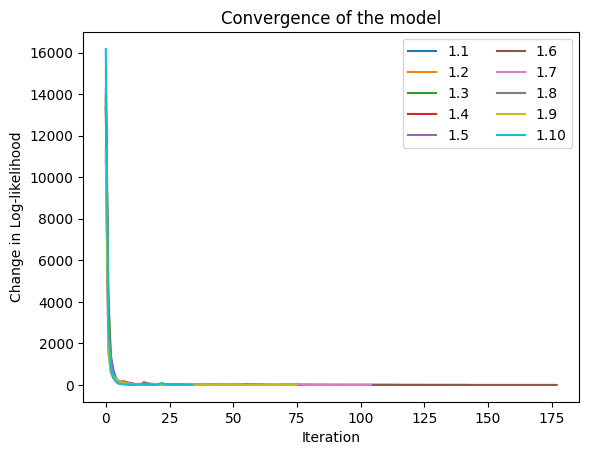


Training and saving models done!!!


In [15]:
# Load mô hình đã huấn luyện
def load_models():
    with open('D:/PBL5/PBL5_CODE/DemoHMM/model_train/model1.pkl', 'rb') as file:
        models = pickle.load(file)
    return models


# Huấn luyện và lưu mô hình
train_and_save_models(train_data, train_labels)
# Load mô hình đã huấn luyện
trained_models = load_models()

In [16]:
def classify_test_data(X_test, y_test, models):
    y_true = []
    y_predict = []
    for cname in class_names:
        for mfcc, target in zip(X_test[cname], y_test[cname]):
            scores = [models[cname].score(mfcc) for cname in class_names]
            pred = np.argmax(scores)
            y_predict.append(pred)
            y_true.append(target)

    # In báo cáo phân loại
    report = classification_report(y_true, y_predict, target_names=class_names, output_dict=True)
    print(report)

    # Chuyển đổi báo cáo thành DataFrame
    report_df = pd.DataFrame(report).transpose()
    # Xuất DataFrame vào tệp Excel
    report_df.to_excel("report1.xlsx")

    # In ma trận nhầm lẫn
    cm = confusion_matrix(y_true, y_predict)

    # Trực quan hóa ma trận nhầm lẫn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Tính độ chính xác
    accuracy = np.sum(cm.diagonal()) / np.sum(cm)
    accuracy = np.round(accuracy, 4)
    print("Accuracy:", accuracy*100, "%")

{'1.1': {'precision': 1.0, 'recall': 0.7, 'f1-score': 0.8235294117647058, 'support': 10.0}, '1.2': {'precision': 0.9090909090909091, 'recall': 1.0, 'f1-score': 0.9523809523809523, 'support': 10.0}, '1.3': {'precision': 0.8333333333333334, 'recall': 1.0, 'f1-score': 0.9090909090909091, 'support': 10.0}, '1.4': {'precision': 0.9090909090909091, 'recall': 1.0, 'f1-score': 0.9523809523809523, 'support': 10.0}, '1.5': {'precision': 1.0, 'recall': 0.9, 'f1-score': 0.9473684210526315, 'support': 10.0}, '1.6': {'precision': 0.9090909090909091, 'recall': 1.0, 'f1-score': 0.9523809523809523, 'support': 10.0}, '1.7': {'precision': 0.9090909090909091, 'recall': 1.0, 'f1-score': 0.9523809523809523, 'support': 10.0}, '1.8': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10.0}, '1.9': {'precision': 1.0, 'recall': 0.9, 'f1-score': 0.9473684210526315, 'support': 10.0}, '1.10': {'precision': 1.0, 'recall': 0.9, 'f1-score': 0.9473684210526315, 'support': 10.0}, 'accuracy': 0.94, 'macro avg

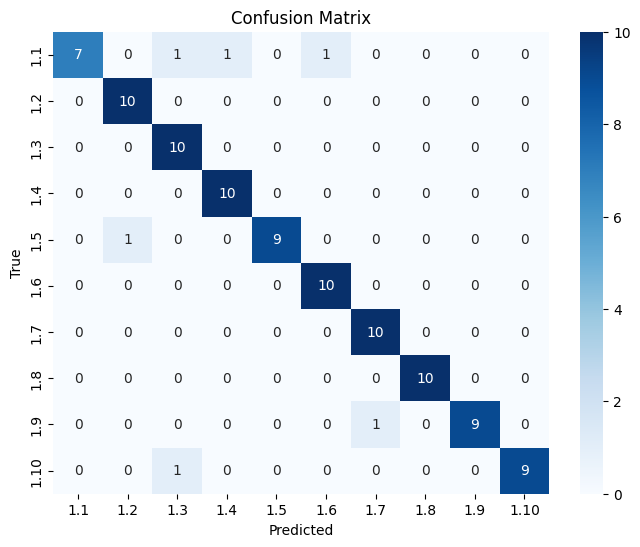

Accuracy: 94.0 %


In [17]:
# Phân loại dữ liệu kiểm tra
test_data, test_labels = prepare_data('D:/PBL5/PBL5_CODE/DemoHMM/DATASET_phanloai/test')
# Phân loại dữ liệu kiểm tra và xuất báo cáo
classify_test_data(test_data, test_labels, trained_models)

In [18]:
# classify_test_data(train_data, train_labels, trained_models)